In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import torch
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import albumentations
import matplotlib.pyplot as plt 
import tensorflow as tf 
import cv2 as cv 
from PIL import Image
import seaborn as sns
import plotly.express as px
import string
import re
from sklearn.metrics.pairwise import cosine_similarity
from skimage.io import imread
from skimage.measure import label as lab

torch.cuda.empty_cache()
#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)

In [ ]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

In [ ]:
from typing import Tuple,List

In [ ]:
def create_hdf5(dataset_name: str,
                train_size: int,
                valid_size: int,
                img_size: Tuple[int, int],
                in_channels: int=3):
    """
    Create empty training and validation HDF5 files with placeholders
    for images and labels (density maps).
    Note:
    Datasets are saved in [dataset_name]/train.h5 and [dataset_name]/valid.h5.
    Existing files will be overwritten.
    Args:
        dataset_name: used to create a folder for train.h5 and valid.h5
        train_size: no. of training samples
        valid_size: no. of validation samples
        img_size: (width, height) of a single image / density map
        in_channels: no. of channels of an input image
    Returns:
        A tuple of pointers to training and validation HDF5 files.
    """
    # create output folder if it does not exist
    os.makedirs(dataset_name, exist_ok=True)

    # create HDF5 files: [dataset_name]/(train | valid).h5
    train_h5 = h5py.File(os.path.join(dataset_name, 'train.h5'), 'w')
    valid_h5 = h5py.File(os.path.join(dataset_name, 'valid.h5'), 'w')

    # add two HDF5 datasets (images and labels) for each HDF5 file
    for h5, size in ((train_h5, train_size), (valid_h5, valid_size)):
        h5.create_dataset('images', (size, in_channels, *img_size))
        h5.create_dataset('labels', (size, 1, *img_size))

    return train_h5, valid_h5


def get_and_unzip(url: str, location: str="."):
    """Extract a ZIP archive from given URL.
    Args:
        url: url of a ZIP file
        location: target location to extract archive in
    """
    dataset = wget.download(url)
    dataset = zipfile.ZipFile(dataset)
    dataset.extractall(location)
    dataset.close()
    os.remove(dataset.filename)

def generate_label(label_info: np.array, image_shape: List[int]):
    """
    Generate a density map based on objects positions.
    Args:
        label_info: (x, y) objects positions
        image_shape: (width, height) of a density map to be generated
    Returns:
        A density map.
    """
    # create an empty density map
    label = np.zeros(image_shape, dtype=np.float32)

    # loop over objects positions and marked them with 100 on a label
    # note: *_ because some datasets contain more info except x, y coordinates
    for x, y, *_ in label_info:
        if y < image_shape[0] and x < image_shape[1]:
            label[int(y)][int(x)] = 100

    # apply a convolution with a Gaussian kernel
    label = gaussian_filter(label, sigma=(1, 1), order=0)

    return label
    

In [ ]:
!ls /

bin	 datalab  home	 lib64	opt   run   sys		       tools
boot	 dev	  lib	 media	proc  sbin  tensorflow-1.15.2  usr
content  etc	  lib32  mnt	root  srv   tmp		       var


In [ ]:
def generate_ucsd_data():
    """Generate HDF5 files for mall dataset."""
    # download and extract data
    get_and_unzip(
        'http://www.svcl.ucsd.edu/projects/peoplecnt/db/ucsdpeds.zip'
    )
    # download and extract annotations
    get_and_unzip(
        'http://www.svcl.ucsd.edu/projects/peoplecnt/db/vidf-cvpr.zip'
    )
    # create training and validation HDF5 files
    train_h5, valid_h5 = create_hdf5('ucsd',
                                     train_size=1500,
                                     valid_size=500,
                                     img_size=(160, 240),
                                     in_channels=1)

    def fill_h5(h5, labels, video_id, init_frame=0, h5_id=0):
        """
        Save images and labels in given HDF5 file.
        Args:
            h5: HDF5 file
            labels: the list of labels
            video_id: the id of a scene
            init_frame: the first frame in given list of labels
            h5_id: next dataset id to be used
        """
        video_name = f"vidf1_33_00{video_id}"
        video_path = f"ucsdpeds/vidf/{video_name}.y/"

        for i, label in enumerate(labels, init_frame):
            # path to the next frame (convention: [video name]_fXXX.jpg)
            img_path = f"{video_path}/{video_name}_f{str(i+1).zfill(3)}.png"

            # get an image as numpy array
            image = np.array(Image.open(img_path), dtype=np.float32) / 255
            # generate a density map by applying a Gaussian filter
            label = generate_label(label[0][0][0], image.shape)

            # pad images to allow down and upsampling
            image = np.pad(image, 1, 'constant', constant_values=0)
            label = np.pad(label, 1, 'constant', constant_values=0)

            # save data to HDF5 file
            h5['images'][h5_id + i - init_frame, 0] = image
            h5['labels'][h5_id + i - init_frame, 0] = label

    # dataset contains 10 scenes
    for scene in range(10):
        # load labels infomation from provided MATLAB file
        # it is numpy array with (x, y) objects position for subsequent frames
        descriptions = loadmat(f'vidf-cvpr/vidf1_33_00{scene}_frame_full.mat')
        labels = descriptions['frame'][0]

        #print(ok)

        # use first 150 frames for training and the last 50 for validation
        # start filling from the place last scene finished
        fill_h5(train_h5, labels[:150], scene, 0, 150 * scene)
        fill_h5(valid_h5, labels[150:], scene, 150, 50 * scene)

    # close HDF5 files
    train_h5.close()
    valid_h5.close()

    # cleanup
    shutil.rmtree('ucsdpeds')
    shutil.rmtree('vidf-cvpr')


In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=ad0962b35eba39cfdb35783959c704405064ac18a6555db2af9126fb5d05f81e
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [ ]:
import os
import shutil
import zipfile
from glob import glob
from typing import List, Tuple

import click
import h5py
import wget
import numpy as np
from PIL import Image
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter


def get_data(dataset: str):
    """
    Get chosen dataset and generate HDF5 files with training
    and validation samples.
    """
    # dictionary-based switch statement
    {
        'ucsd': generate_ucsd_data
    }[dataset]()

In [ ]:
get_data('ucsd')

In [ ]:
import os
from random import random
from typing import Optional

import h5py
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader


class H5Dataset(Dataset):
    """PyTorch dataset for HDF5 files generated with `get_data.py`."""

    def __init__(self,
                 dataset_path: str,
                 horizontal_flip: float=0.0,
                 vertical_flip: float=0.0):
        """
        Initialize flips probabilities and pointers to a HDF5 file.
        Args:
            dataset_path: a path to a HDF5 file
            horizontal_flip: the probability of applying horizontal flip
            vertical_flip: the probability of applying vertical flip
        """
        super(H5Dataset, self).__init__()
        self.h5 = h5py.File(dataset_path, 'r')
        self.images = self.h5['images']
        self.labels = self.h5['labels']
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip

    def __len__(self):
        """Return no. of samples in HDF5 file."""
        return len(self.images)

    def __getitem__(self, index: int):
        """Return next sample (randomly flipped)."""
        # if both flips probabilities are zero return an image and a label
        if not (self.horizontal_flip or self.vertical_flip):
            return self.images[index], self.labels[index]

        # axis = 1 (vertical flip), axis = 2 (horizontal flip)
        axis_to_flip = []

        if random() < self.vertical_flip:
            axis_to_flip.append(1)

        if random() < self.horizontal_flip:
            axis_to_flip.append(2)

        return (np.flip(self.images[index], axis=axis_to_flip).copy(),
                np.flip(self.labels[index], axis=axis_to_flip).copy())

In [ ]:
batch_size = 4
learning_rate = 0.001
n_epoch = 30
horizontal_flip = 0.0
vertical_flip = 0.0


In [ ]:
!ls

drive  sample_data  ucsd


In [ ]:
dataset_name = 'ucsd'

In [ ]:

import torchvision
'''
resnet = torchvision.models.resnet.resnet50(pretrained=True)


class ConvBlock(nn.Module):
    """
    Helper module that consists of a Conv -> BN -> ReLU
    """

    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x


class Bridge(nn.Module):
    """
    This is the middle layer of the UNet which just consists of some
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)


class UpBlockForUNetWithResNet50(nn.Module):
    """
    Up block that encapsulates one up-sampling step which consists of Upsample -> ConvBlock -> ConvBlock
    """

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 upsampling_method="conv_transpose"):
        super().__init__()

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            )
        self.conv_block_1 = ConvBlock(in_channels, out_channels)
        self.conv_block_2 = ConvBlock(out_channels, out_channels)

    def forward(self, up_x, down_x):
        """
        :param up_x: this is the output from the previous up block
        :param down_x: this is the output from the down block
        :return: upsampled feature map
        """
        x = self.upsample(up_x)
        x = torch.cat([x, down_x], 1)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x


class UNetWithResnet50Encoder(nn.Module):
    DEPTH = 6

    def __init__(self, n_classes=2):
        super().__init__()
        resnet = torchvision.models.resnet.resnet50(pretrained=True)
        down_blocks = []
        up_blocks = []
        self.input_block = nn.Sequential(*list(resnet.children()))[:3]
        self.input_pool = list(resnet.children())[3]
        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)
        self.down_blocks = nn.ModuleList(down_blocks)
        self.bridge = Bridge(2048, 2048)
        up_blocks.append(UpBlockForUNetWithResNet50(2048, 1024))
        up_blocks.append(UpBlockForUNetWithResNet50(1024, 512))
        up_blocks.append(UpBlockForUNetWithResNet50(512, 256))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=128 + 64, out_channels=128,
                                                    up_conv_in_channels=256, up_conv_out_channels=128))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=64 + 3, out_channels=64,
                                                    up_conv_in_channels=128, up_conv_out_channels=64))

        self.up_blocks = nn.ModuleList(up_blocks)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1, stride=1)

    def forward(self, x, with_output_feature_map=False):
        pre_pools = dict()
        pre_pools[f"layer_0"] = x
        x = self.input_block(x)
        pre_pools[f"layer_1"] = x
        x = self.input_pool(x)

        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            if i == (UNetWithResnet50Encoder.DEPTH - 1):
                continue
            pre_pools[f"layer_{i}"] = x

        x = self.bridge(x)

        for i, block in enumerate(self.up_blocks, 1):
            key = f"layer_{UNetWithResnet50Encoder.DEPTH - 1 - i}"
            x = block(x, pre_pools[key])
        output_feature_map = x
        x = self.out(x)
        del pre_pools
        if with_output_feature_map:
            return x, output_feature_map
        else:
            return x
'''

'\nresnet = torchvision.models.resnet.resnet50(pretrained=True)\n\n\nclass ConvBlock(nn.Module):\n    """\n    Helper module that consists of a Conv -> BN -> ReLU\n    """\n\n    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):\n        super().__init__()\n        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)\n        self.bn = nn.BatchNorm2d(out_channels)\n        self.relu = nn.ReLU()\n        self.with_nonlinearity = with_nonlinearity\n\n    def forward(self, x):\n        x = self.conv(x)\n        x = self.bn(x)\n        if self.with_nonlinearity:\n            x = self.relu(x)\n        return x\n\n\nclass Bridge(nn.Module):\n    """\n    This is the middle layer of the UNet which just consists of some\n    """\n\n    def __init__(self, in_channels, out_channels):\n        super().__init__()\n        self.bridge = nn.Sequential(\n            ConvBlock(in_channels, out

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=2, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        #print(x.shape)
        logits = self.outc(x)
        #print(logits.shape)
        #print(ok)
        return logits

In [ ]:
from collections import defaultdict
import torch.nn.functional as F
import copy
from sklearn.metrics import jaccard_similarity_score

def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

smooth = 1e-12

def jaccard_approx(pred, target, smooth=1e-12 ):
    #intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    #sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    sum_ = (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2))

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return jac.mean()

def calc_loss(pred, target, metrics, bce_weight=0.5):
    #print(pred.shape)
    #print(target.shape)
    bce = F.binary_cross_entropy_with_logits(pred, target)
    MSE = torch.nn.MSELoss()
    mse = MSE(pred,target)
    #pred = F.sigmoid(pred)

    #dice = dice_loss(pred, target)
    #loss = bce * bce_weight + dice * (1 - bce_weight)
    loss = 10*bce + 1000*mse
    #loss = torch.log(jaccard_approx(pred,target))
    #loss = jaccard_approx(pred, target )
    #loss = dice

    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)


    return loss
from sklearn.metrics import mean_squared_error

def update_errors(true_values,predicted_values,size):
    """
    Calculate errors and standard deviation based on current
    true and predicted values.
    """
    err = [true - predicted for true, predicted in
                zip(true_values, predicted_values)]
    abs_err = [abs(error) for error in err]
    mean_err = sum(err) / size
    mean_abs_err = sum(abs_err) / size
    #std = np.array(err).std()



    #rmse = mean_squared_error(true_values, predicted_values, squared=False)

    return mean_abs_err

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))


train_loss = []
test_loss = []
mean_abs_err_train = []
mean_abs_err_test = []

def train_model(model, optimizer, scheduler, num_epochs=10):
    #best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

      # Each epoch has a training and validation phase

        
        for param_group in optimizer.param_groups:
            print("LR", param_group['lr'])
        print('Started training')

        model.train()  # Set model to training mode

        true_values = []
        predicted_values = []


        metrics = defaultdict(float)
        epoch_samples = 0

        for inputs,labels in dataloader['train']:
            #print(dataloaders['train'])
            #print('Entered')
            inputs = inputs.to(device)
            #print(inputs['image'].shape)
            labels = labels.to(device)  

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train

            outputs = model(inputs)
            #outputs = torch.max(outputs,torch.tensor([0.]).to(device))
            loss = calc_loss(outputs, labels, metrics)

            # backward + optimize only if in training phase
            loss.backward()
            optimizer.step()

            # statistics
            epoch_samples += inputs.size(0)


            # loop over batch samples
            for true, predicted in zip(labels, outputs):
                # integrate a density map to get no. of objects
                # note: density maps were normalized to 100 * no. of objects
                #       to make network learn better
                true_counts = torch.sum(true).item() / 100
                #predicted_counts = torch.sum(predicted).item() / 100

                p=torch.nn.functional.relu(predicted).cpu().detach().numpy() # contains a prediction result
                # normalize threshold to 0 or 1
                i = p >= 0.5
                p[i] = 1
                i = p < 0.5
                p[i] = 0
                labeled_array, num_features = lab(p, return_num=True)
                #predicted_counts = torch.sum(predicted).item() / 100
                predicted_counts = num_features

                # update current epoch results
                true_values.append(true_counts)
                predicted_values.append(predicted_counts)


        print_metrics(metrics, epoch_samples, 'train')
        epoch_loss = metrics['loss'] / epoch_samples
        train_loss.append(epoch_loss)

        mean_abs_err = update_errors(true_values,predicted_values,len(dataset['train']))
        mean_abs_err_train.append(mean_abs_err)

        #torch.save(model,f'/content/drive/My Drive/cars_latest/resunet50_epoch_{e}_1.pt')

        #train_score, trs = calc_jacc_img_msk(model, inputs['image'].cpu().numpy(), inputs['segmented_mask'].cpu().numpy(), 8, 1)
        scheduler.step()


        #set model in evaluation mode
        model.eval()
        avg_loss = 0
        true_values = []
        predicted_values = []

        metrics = defaultdict(float)
        epoch_samples=0
        
        for inputs,labels in dataloader['valid']:

            #print(dataloaders['train'])
            inputs = inputs.to(device)
            #print(inputs['image'].shape)
            labels = labels.to(device)            

            outputs = model(inputs)
            #outputs = torch.max(outputs,torch.tensor([0.]).to(device))

            loss = calc_loss(outputs, labels, metrics)
            epoch_samples += inputs.size(0)

            # loop over batch samples
            for true, predicted in zip(labels, outputs):
                # integrate a density map to get no. of objects
                # note: density maps were normalized to 100 * no. of objects
                #       to make network learn better
                true_counts = torch.sum(true).item() / 100
                #predicted_counts = torch.sum(predicted).item() / 100
                
                p=torch.nn.functional.relu(predicted).cpu().detach().numpy() # contains a prediction result
                # normalize threshold to 0 or 1
                i = p >= 0.5
                p[i] = 1
                i = p < 0.5
                p[i] = 0
                labeled_array, num_features = lab(p, return_num=True)
                #predicted_counts = torch.sum(predicted).item() / 100
                predicted_counts = num_features
                

                # update current epoch results
                true_values.append(true_counts)
                predicted_values.append(predicted_counts)
        
        print_metrics(metrics, epoch_samples, 'val')
        epoch_loss = metrics['loss'] / epoch_samples
        test_loss.append(epoch_loss)


        mean_abs_err = update_errors(true_values,predicted_values,len(dataset['valid']))
        mean_abs_err_test.append(mean_abs_err)

        print(true_values)
        print(predicted_values)


        #print("\n")
        print("Epoch: ", epoch, "Train Loss: ", train_loss[-1], "Test Loss: ", test_loss[-1], "Train MAE: ", mean_abs_err_train[-1], "Test MAE: ", mean_abs_err_test[-1])

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print("\n")
        #print(ok)
        if (epoch%10==0) or (epoch==(num_epochs-1)):
      
          torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss[-1],
                }, f'/content/drive/My Drive/UCSD_Counting/epoch_{epoch+10+17+11}_trainmae_{mean_abs_err_train[-1]}_testmae_{mean_abs_err_test[-1]}_unet.pt')
        


    #print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    #model.load_state_dict(best_model_wts)
    return model

In [ ]:
"""Train chosen model on selected dataset."""
# use GPU if avilable
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

dataset = {}     # training and validation HDF5-based datasets
dataloader = {}  # training and validation dataloaders

for mode in ['train', 'valid']:
    # expected HDF5 files in dataset_name/(train | valid).h5
    data_path = os.path.join(dataset_name, f"{mode}.h5")
    # turn on flips only for training dataset
    dataset[mode] = H5Dataset(data_path,
                              horizontal_flip if mode == 'train' else 0,
                              vertical_flip if mode == 'train' else 0)
    dataloader[mode] = torch.utils.data.DataLoader(dataset[mode],
                                                    batch_size=batch_size)

In [ ]:
#!pip install segmentation-models-pytorch


In [ ]:
#import segmentation_models_pytorch as smp


In [ ]:
'''
model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)
'''

'\nmodel = smp.Unet(\n    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7\n    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization\n    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)\n    classes=1,                      # model output channels (number of classes in your dataset)\n)\n'

In [ ]:
# define loss function
#model = UNetWithResnet50Encoder(n_classes=1)
model = UNet(n_classes=1)

# setup SGD
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,weight_decay=0.005)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

gpu_flag = torch.cuda.is_available()
print(gpu_flag)
if gpu_flag:
    model = model.cuda()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#print(model)

True


In [ ]:
path = '/content/drive/My Drive/UCSD_Counting/epoch_10_trainmae_5.8952401936848995_testmae_3.6059998535156277_unet.pt'
model_class = torch.load(path)

In [ ]:
model.load_state_dict(model_class['model_state_dict'])

<All keys matched successfully>

In [ ]:
model_trained = train_model(model, optimizer, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
LR 1.0000000000000004e-08
Started training
train: loss: 90.051229
val: loss: 434.950633
[21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.00000244140625, 21.00000244140625, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 22.0, 22.0, 22.0, 22.00000244140625, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.00000244140625, 26.0, 26.0, 26.0, 26.0, 26.00000244140625, 26.0, 26.0, 26.0, 26.00000244140625, 28.0, 28.0, 28.0, 28.00000244140625, 28.0, 28.00000244140625, 28.0, 28.0, 28.0, 28.0, 29.0, 29.00000244140625, 29.0, 29.0, 29.0, 31.0, 31.0, 31.0, 31.0, 31.00000244140625, 31.0, 27.0, 27.0, 27.0, 27.0, 26.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 25.0, 25.00000244140625, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25

KeyboardInterrupt: ignored

In [ ]:
print(len(dataset['train']))

1500


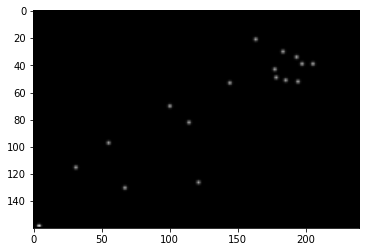

In [ ]:
plt.imshow(dataset['train'][0][1][0,:,:],cmap='gray')

In [ ]:
true_values = []
predicted_values = []


metrics = defaultdict(float)
epoch_samples = 0

for inputs,labels in dataloader['valid']:
    #print(dataloaders['train'])
    #print('Entered')
    inputs = inputs.to(device)
    #print(inputs['image'].shape)
    labels = labels.to(device)  

    # zero the parameter gradients
    #optimizer.zero_grad()

    # forward
    # track history if only in train

    outputs = model(inputs)
    #outputs = torch.max(outputs,torch.tensor([0.]).to(device))
    loss = calc_loss(outputs, labels, metrics)

    # backward + optimize only if in training phase
    #loss.backward()
    #optimizer.step()

    # statistics
    epoch_samples += inputs.size(0)



    # loop over batch samples
    for true, predicted in zip(labels, outputs):
        # integrate a density map to get no. of objects
        # note: density maps were normalized to 100 * no. of objects
        #       to make network learn better
        true_counts = torch.sum(true).item() / 100
        #predicted = torch.max(predicted,torch.tensor([0.]).to(device))
        p=torch.nn.functional.relu(predicted).cpu().detach().numpy() # contains a prediction result
        # normalize threshold to 0 or 1
        i = p >= 0.5
        p[i] = 1
        i = p < 0.5
        p[i] = 0
        labeled_array, num_features = lab(p, return_num=True)
        #predicted_counts = torch.sum(predicted).item() / 100
        predicted_counts = num_features

        # update current epoch results
        true_values.append(true_counts)
        predicted_values.append(predicted_counts)
    print(loss)
    print(labels.shape)
    print(true_values)
    print(predicted_values)
    print(ok)

tensor(191.4178, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([4, 1, 160, 240])
[21.0, 21.0, 21.0, 21.0]
[21, 20, 22, 24]


NameError: ignored

In [ ]:
print(inputs.shape)

torch.Size([4, 1, 160, 240])


In [ ]:
print(labels[1,0,:,:])

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0040,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0086,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')


In [ ]:
print(torch.sum(outputs[1,0,:,:]))

tensor(-613768.3750, device='cuda:0', grad_fn=<SumBackward0>)


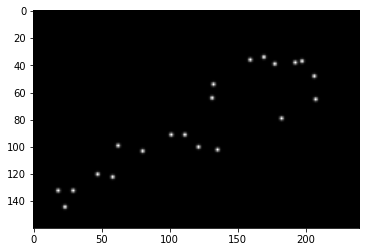

In [ ]:
plt.imshow(labels[1,0,:,:].cpu(),cmap='gray')

In [ ]:
print(outputs[1,0,:,:])

tensor([[-16.5346, -14.4243, -12.8525,  ..., -14.6614, -18.3981, -13.9844],
        [-23.6480, -13.7219, -12.6641,  ..., -12.1405, -11.0656, -15.1848],
        [-26.5412, -17.4505,  -9.7833,  ..., -12.6068, -10.1641, -14.1154],
        ...,
        [-12.5616, -12.5324, -15.5709,  ..., -13.5767, -15.1866, -29.2289],
        [-19.4912, -17.3610, -17.1859,  ...,  -9.7983, -13.4876, -25.1023],
        [-11.6165, -11.6868, -10.9563,  ..., -19.8714, -17.2694, -19.2662]],
       device='cuda:0', grad_fn=<SliceBackward>)


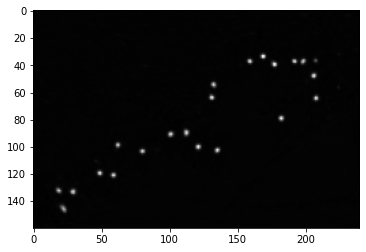

In [ ]:
plt.imshow(outputs[1,0,:,:].cpu().detach().numpy(),cmap='gray')

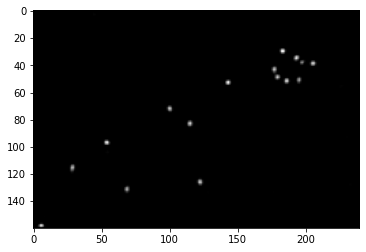

In [ ]:
plt.imshow(torch.nn.functional.relu(outputs[1,0,:,:]).cpu().detach().numpy(),cmap='gray')

In [ ]:
#true = dataset['train'][0][1][0,:,:]
#print(true.shape)
true_counts = torch.sum(labels[3,0,:,:]).item() / 100
print(true_counts)


21.0


In [ ]:
print(true_counts)

21.0


In [ ]:
print(torch.nn.functional.relu(outputs[1,0,:,:]))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<ReluBackward0>)


In [ ]:
bins=20

In [ ]:
print(p.shape)

(160, 240)


In [ ]:
histogram, bin_edges = np.histogram(p, bins=256, range=(0, 1))

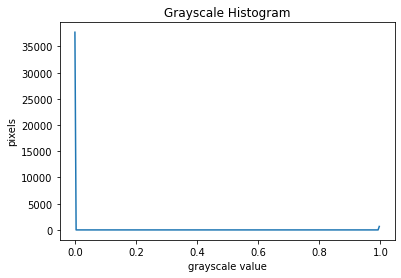

In [ ]:
# configure and draw the histogram figure
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
#plt.xlim([0.0, 1.0])  # <- named arguments do not work here

plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()

24


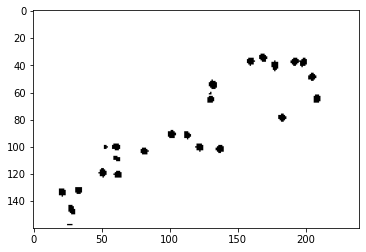

In [ ]:
from scipy.ndimage import label
from skimage.measure import label as lab

p=torch.nn.functional.relu(outputs[3,0,:,:]).cpu().detach().numpy() # contains a prediction result
# normalize threshold to 0 or 1
i = p >= 0.5
p[i] = 1
i = p < 0.5
p[i] = 0
labeled_array, num_features = lab(p, return_num=True)
plt.imshow(p, cmap=plt.cm.binary)
print(num_features)

20


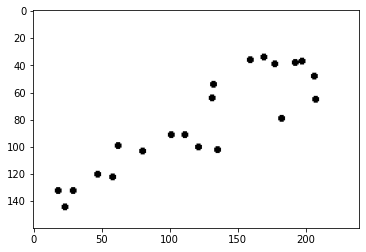

In [ ]:
from scipy.ndimage import label
from skimage.measure import label as lab

p=torch.nn.functional.relu(labels[1,0,:,:]).cpu().numpy() # contains a prediction result
# normalize threshold to 0 or 1
i = p >= 0.5
p[i] = 1
i = p < 0.5
p[i] = 0
labeled_array, num_features = lab(p, return_num=True)
plt.imshow(p, cmap=plt.cm.binary)
print(num_features)

In [ ]:
pred_counts = torch.sum(outputs[1,0,:,:]).item() / 100
print(pred_counts)

27.6093359375


In [ ]:
print(dataset['train'][0][1].shape)

(1, 160, 240)
